In [11]:
import torch
import torch.nn as nn

from tqdm import tqdm

from tools import plot_results, run_experiment, BasicModel, get_flops_and_memory


In [7]:
class ConvFlops(nn.Conv2d):

    """
    Flops are computed for square kernel
    FLOPs = 2 x Cin x Cout x k**2 x Wout x Hout / groups
    We use 2 because 1 for multiplocation and 1 for addition
    Hout = Hin + 2*padding[0] - dilation[0] x (kernel[0]-1)-1
          --------------------------------------------------- + 1
                                stride
    Wout same as above
    NOTE: We do not account for bias term
    """

    def __init__(self, **kwargs):
        super(ConvFlops, self).__init__(**kwargs)
        self.kernel = self.to_tuple(self.kernel_size)

        self.param_size = (
            2
            * self.in_channels
            * self.out_channels
            * self.kernel[0]
            * self.kernel[1]
            / self.groups
        )
        self.flops = 0
        self.memory_size = 0

    def to_tuple(self, value):
        if type(value) == int:
            return (value, value)
        if type(value) == tuple:
            return value

    def forward(self, input_x):
        """
        BATCH x C x W x H
        """
        # get the same device to avoid errors
        output = self._conv_forward(input_x, self.weight, bias=None)

        w_out = output.shape[2]
        h_out = output.shape[3]
        self.b = output.shape[0]

        device = input_x.device

        c_in, w_in, h_in = input_x.shape[1], input_x.shape[2], input_x.shape[3]

        self.memory_size = c_in * w_in * h_in
        self.flops = self.param_size * w_out * h_out

        return output

    def _fetch_info(self):
        return self.b*self.flops, self.memory_size


class LinearFlops(nn.Linear):

    """
    V in R^(m)
    W in R^(mxn)
    FLOPS: 2mn
    """

    def __init__(self, **kwargs):
        super(LinearFlops, self).__init__(**kwargs)

        self.flops = 0
        self.memory_size = 0


    def forward(self, input_x):
        """
        BATCH x m
        """

        output = torch.nn.functional.linear(input_x, self.weight, bias=self.bias)

        device = input_x.device

        n, m, = self.in_features, self.out_features
        self.b = output.shape[0]

        self.memory_size = n*m
        self.flops = 2*n*m

        return output

    def _fetch_info(self):
        # get flops according to the batch size
        return self.b*self.flops, self.memory_size

### Check if it is correctly computed

In [8]:
conv = ConvFlops(in_channels=15,out_channels=3,kernel_size=2)

tensor = torch.rand(7,15,23,21)
conv(tensor)

flops, memory = conv._fetch_info()

assert flops == 1108800.0, "wrong flops numebr"
assert memory == 7245, "wrong memory size"

In [10]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        features_in: int,
        features_out: int,
        layer_type: str = 'linear',
        kernel_size: int = 3,
        dilation: int = 1
        )-> None:
        super().__init__()

        assert layer_type in ['linear','conv'], "layer_type should either linear or conv"

        match layer_type:
            case 'linear':
                self.l1 =  LinearFlops(in_features=features_in,out_features=features_out, bias=1)
                self.l2 = LinearFlops(in_features=features_in,out_features=features_out, bias=1)
                norm_layer = nn.BatchNorm1d

            case 'conv':
                self.l1 =  ConvFlops(in_channels=features_in,out_channels=features_out,kernel_size=kernel_size,  padding=1)
                self.l2 = ConvFlops(in_channels=features_in,out_channels=features_out,kernel_size=kernel_size,  padding=1)
                norm_layer = nn.BatchNorm2d


        self.bn1 = norm_layer(features_out)
        self.relu = nn.ReLU()

        self.bn2 = norm_layer(features_out)


    def forward(self, x) :
        identity = x

        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.l2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

### Experiments :

We wanto investigate how lattency scales with memory size and used memmory

We will run several experiments:

1. Vary an input size
2. Vary a number of blocks
3. Measure performance for both, linear models, convolutional models 
4. Repeat results on CPU and GPU

### Test that everything works as intented:

In [14]:
dummy_tensor = torch.rand(1,64,20,20)

run_experiment(BasicBlock,
               layer_type='conv', 
                   features_in=64, 
                   features_out=64, 
                   dummy_tensor=dummy_tensor, 
                   block_numbers=1, 
                   device=1, 
                   n_runs = 1000)

{'mean_time': 1.4360620766878127,
 'std_time': 0.07505615384999156,
 'flops': 58982400.0,
 'memory': 51200}

# Linear layer varied input size GPU:

linear_sizes = [10,100, 500, 1000, 5000] 

In [15]:
linear_sizes = [10,100, 500, 1000, 5000, 10000] 

results = {'mean_time':[], 'std_time':[],  'flops':[],'memory':[]}

for sisze in tqdm(linear_sizes):

    dummy_tensor = torch.rand(1,sisze,sisze)

    r = run_experiment(BasicBlock,
                       layer_type='linear', 
                    features_in=sisze, 
                    features_out=sisze, 
                    dummy_tensor=dummy_tensor, 
                    block_numbers=1, 
                    device=1, 
                    n_runs = 500)

    for k in results: results[k].append(r[k])

100%|██████████| 6/6 [02:18<00:00, 23.14s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


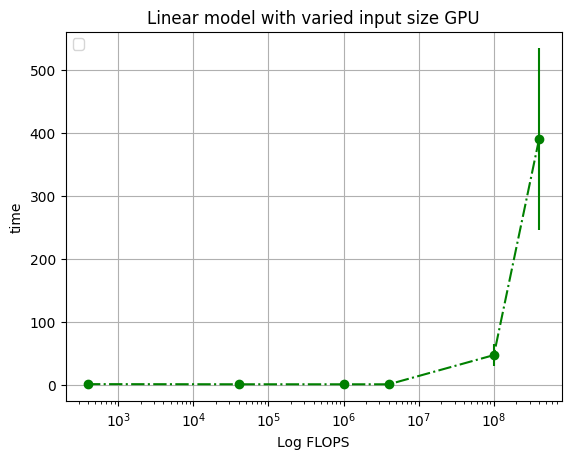

In [16]:
plot_results(results, name='Linear model with varied input size GPU')

100%|██████████| 6/6 [32:20<00:00, 323.40s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


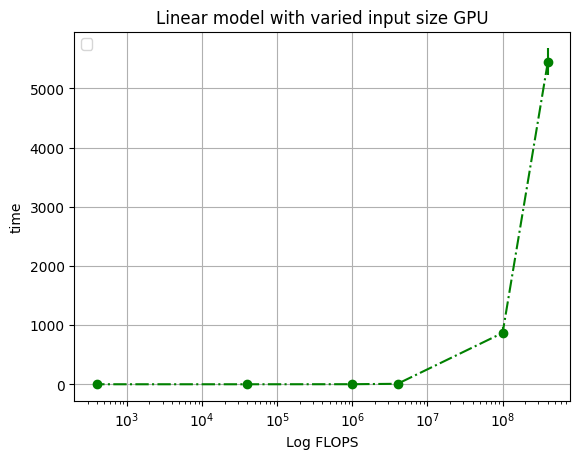

In [18]:
linear_sizes = [10,100, 500, 1000, 5000, 10000] 

results = {'mean_time':[], 'std_time':[],  'flops':[],'memory':[]}

for sisze in tqdm(linear_sizes):

    dummy_tensor = torch.rand(1,sisze,sisze)

    r = run_experiment(BasicBlock,
                       layer_type='linear', 
                    features_in=sisze, 
                    features_out=sisze, 
                    dummy_tensor=dummy_tensor, 
                    block_numbers=1, 
                    device='cpu', 
                    n_runs = 500)

    for k in results: results[k].append(r[k])


plot_results(results, name='Linear model with varied input size CPU')

In [19]:
num_bocks = [5,10, 100, 150, 200, 300] 

results = {'mean_time':[], 'std_time':[],  'flops':[],'memory':[]}

for b_sisze in tqdm(linear_sizes):

    dummy_tensor = torch.rand(1,100,100)

    r = run_experiment(BasicBlock,
                       layer_type='linear', 
                    features_in=100, 
                    features_out=100, 
                    dummy_tensor=dummy_tensor, 
                    block_numbers=b_sisze, 
                    device=1, 
                    n_runs = 500)

    for k in results: results[k].append(r[k])


plot_results(results, name='Linear model with varied number of blocks on GPU')

  0%|          | 0/6 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x10 and 100x100)

In [ ]:
linear_sizes = [32,64, 128, 256, 512, 1024] 

results = {'mean_time':[], 'std_time':[],  'flops':[],'memory':[]}

for sisze in tqdm(linear_sizes):

    dummy_tensor = torch.rand(1,sisze,sisze)

    r = run_experiment(BasicBlock,
                       layer_type='linear', 
                    features_in=sisze, 
                    features_out=sisze, 
                    dummy_tensor=dummy_tensor, 
                    block_numbers=1, 
                    device=1, 
                    n_runs = 500)

    for k in results: results[k].append(r[k])